<a href="https://colab.research.google.com/github/namanwahi/notebooks/blob/main/tfp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
% pip install shap
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import shap
import numpy as np
from sklearn.datasets import make_regression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
N_BINS = 7
INPUT_SIZE = 15

In [3]:
X, y_c = make_regression(
    n_samples=100000,
    n_features=INPUT_SIZE,
    n_informative=6,
    bias=123.43,
)


discretizer = KBinsDiscretizer(
    n_bins=N_BINS,
    encode="onehot-dense",
    strategy="quantile",
)
y = discretizer.fit_transform(y_c.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2)

X_train = X_train.astype("float32")
y_train = y_train.astype("float32")
X_test = X_test.astype("float32")
y_test = y_test.astype("float32")
bin_edges = discretizer.bin_edges_[0].astype("float32")

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Bin edges ", bin_edges)

(99998, 15)
(99998, 7)
(2, 15)
(2, 7)
Bin edges  [-413.69955     -0.8312245   57.495453   102.59379    144.2777
  189.16661    248.55219    650.0247   ]


In [4]:
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(INPUT_SIZE,)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(N_BINS, activation="softmax"),
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 217       
Total params: 697
Trainable params: 697
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.fit(
    x=X_train,
    y=y_train,
    epochs=1,
    batch_size=512,
)

196/196 [==============================] - 1s 1ms/step - loss: 2.1376


In [6]:
predictions = model.predict(X_test)
print(predictions.shape)

(2, 7)


In [7]:
print("Probability density", predictions[0].tolist())

Probability density [0.1556439995765686, 0.08206197619438171, 0.10242743790149689, 0.3167668879032135, 0.18893329799175262, 0.04446696117520332, 0.10969946533441544]


In [8]:
quantized_dist = tfp.distributions.MixtureSameFamily(
    mixture_distribution=tfp.distributions.Categorical(probs=predictions[0]),
    components_distribution=tfp.distributions.Uniform(low=bin_edges[:-1], high=bin_edges[1:])
)

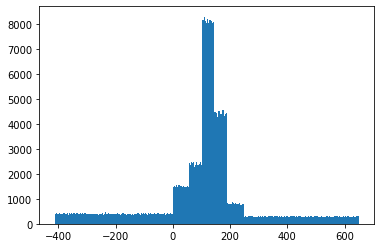

In [9]:
samples = quantized_dist.sample(sample_shape=(1000000,))
plt.hist(samples, bins=1000)
plt.show()

In [10]:
quantized_dist.cdf(0.0)
#quantized_dist.quantile(0.5)

<tf.Tensor: shape=(), dtype=float32, numpy=0.15681346>

In [11]:
def sampled_median(X, bin_edges, model):
  probabilities = model(X)
  batched_bin_edges = np.broadcast_to(bin_edges, (X.shape[0], N_BINS + 1))
  quantized_dist = tfp.distributions.MixtureSameFamily(
    mixture_distribution=tfp.distributions.Categorical(probs=probabilities),
    components_distribution=tfp.distributions.Uniform(low=batched_bin_edges[:, :-1], high=batched_bin_edges[:, 1:])
  )

  return tfp.stats.percentile(quantized_dist.sample(100000), 50.0, axis=0)


sampled_median(X_test, bin_edges, model)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([123.852684, 134.0031  ], dtype=float32)>

In [14]:
def analytic_median(X, bin_edges, model):
  probabilities = model(X)
  bin_widths = np.diff(bin_edges)
  bin_masses = probabilities * bin_widths
  cum_bin_masses = tf.cumsum(bin_masses, axis=1)
  median_mass = (cum_bin_masses[:, -1] + cum_bin_masses[:, 0]) / 2
  median_mass = tf.expand_dims(median_mass, axis=1)
  median_bin = tf.searchsorted(cum_bin_masses, median_mass)
  print(tf.gather_nd(cum_bin_masses, median_bin, batch_dims=1).numpy().tolist())
  print(median_mass.numpy().tolist())
  print(tf.gather_nd(bin_masses, median_bin, batch_dims=1).numpy().tolist())
  return median_bin

res = analytic_median(X_test, bin_edges, model)
print(res)

[142.03329467773438, 175.73928833007812]
[[103.14688110351562], [127.27267456054688]]
[44.04132080078125, 67.04411315917969]
tf.Tensor(
[[6]
 [6]], shape=(2, 1), dtype=int32)


In [13]:
np.broadcast_to(bin_edges, (3, 8)).shape

(3, 8)